In [1]:
import os
import sys
import random
from PIL import Image
import numpy as np
import pandas as pd
#for image transform
import cv2

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import random
import time

sys.path.insert(1, '//workspace/dl2020')
#from model_loader_CP2 import *
from CP_helper_RCNN import *
from data_helper_RCNN import *

#from Unet import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.utils.data


 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
#from engine import train_one_epoch, evaluate


from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

%load_ext autoreload
%autoreload 2
%load_ext autotime

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);
image_folder = '../data'
annotation_csv = '../data/annotation.csv'

time: 4.95 ms


In [6]:
# import torchvision
# from torchvision.models.detection import FasterRCNN
# from torchvision.models.detection.rpn import AnchorGenerator
# from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

# # load a pre-trained model for classification and return
# # only the features
# #backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# backbone = resnet_fpn_backbone('resnet18', pretrained = False)
# # FasterRCNN needs to know the number of
# # output channels in a backbone. For mobilenet_v2, it's 1280
# # so we need to add it here
# #backbone.out_channels = 1280
# backbone.out_channels = 256 #this is a guess


# # let's make the RPN generate 5 x 3 anchors per spatial
# # location, with 5 different sizes and 3 different aspect
# # ratios. We have a Tuple[Tuple[int]] because each feature
# # map could potentially have different sizes and
# # aspect ratios
# anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
#                                    aspect_ratios=((0.5, 1.0, 2.0),))

# # let's define what are the feature maps that we will
# # use to perform the region of interest cropping, as well as
# # the size of the crop after rescaling.
# # if your backbone returns a Tensor, featmap_names is expected to
# # be [0]. More generally, the backbone should return an
# # OrderedDict[Tensor], and in featmap_names you can choose which
# # feature maps to use.
# roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
#                                                 output_size=7,
#                                                 sampling_ratio=2)

# # put the pieces together inside a FasterRCNN model
# model = FasterRCNN(backbone,
#                    num_classes=2,
#                    rpn_anchor_generator=anchor_generator,
#                    box_roi_pool=roi_pooler)

In [3]:
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)
train_labeled_scene_index, val_labeled_scene_index  = gen_train_val_index(labeled_scene_index)

time: 2.78 ms


In [4]:
#normalize = torchvision.transforms.Normalize(mean=[0.6394939, 0.6755114, 0.7049375],
#                                     std=[0.31936955, 0.3117349 , 0.2953726 ])

#transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
#                                           normalize
#                                           ])

transform = transforms.ToTensor()

kwargs = {
    #'first_dim': 'sample',
    'transform': transform,
    'image_folder': image_folder,
    'annotation_file': annotation_csv,
    'extra_info': True}

#dataset_train = LabeledDataset_RCNN (scene_index=train_labeled_scene_index, **kwargs)
#dataset_val = LabeledDataset_RCNN (scene_index=val_labeled_scene_index, **kwargs)

dataset_train = LabeledDataset(scene_index=train_labeled_scene_index, **kwargs)
dataset_val = LabeledDataset(scene_index=val_labeled_scene_index, **kwargs)





train_data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

val_data_loader = torch.utils.data.DataLoader(
    dataset_val, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

time: 802 ms


In [5]:
#mod = torchvision.models.resnet50()

time: 1.31 ms


In [6]:
#check one sample from validation
for i, (sample, old_targets, road_image, extra) in enumerate(val_data_loader): #, print_freq, header): 
        
        images = sample
        targets = trans_target(old_targets)
        #print("images len {}, targets len {}".format(len(images), len(targets)))
        #print("images[0] shape {}".format(images[0].shape)) # [6, 3, 256, 306]      
        #images = list(image.to(device) for image in images)
        #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        break

time: 627 ms


In [7]:
normalize = torchvision.transforms.Normalize(mean=[0.6394939, 0.6755114, 0.7049375],
                                 std=[0.31936955, 0.3117349 , 0.2953726 ])

tt = transforms.Compose([transforms.Resize((800, 800)), transforms.ToTensor(), normalize]) 

time: 3.45 ms


In [8]:
images = [tt(sew_images(s)) for s in sample] #list of [3, 800, 800], should be 1 per patch
targets = trans_target(old_targets)
        
         

time: 183 ms


In [9]:
images[0].shape

torch.Size([3, 800, 800])

time: 7.79 ms


In [10]:
images[0].max()

tensor(1.1288)

time: 14.6 ms


In [11]:
targets

({'boxes': tensor([[587.7640, 390.4039, 634.5888, 410.7347],
          [723.5701, 494.8876, 770.2949, 515.9766],
          [346.5826, 625.2436, 392.2856, 643.8907],
          [208.3556, 429.6745, 252.5559, 448.8516],
          [103.3553, 430.6902, 147.5497, 449.4175],
          [ 31.1752, 463.0602,  79.2614, 483.2730],
          [340.5685, 465.9312, 384.6458, 484.8769],
          [648.6622, 555.0985, 696.0050, 573.7671],
          [496.1005, 585.7907, 541.8034, 604.4378],
          [519.1313, 464.6352, 561.6338, 483.1805],
          [ 25.9092, 359.7119,  71.8441, 382.5251],
          [716.3273, 617.2219, 763.7090, 636.7295],
          [321.8503, 425.9930, 395.7314, 448.2401],
          [271.5695, 590.2742, 317.2724, 608.9213],
          [384.5264, 589.7536, 430.2294, 608.4007],
          [ 66.1751, 394.0988, 110.3829, 413.8457],
          [256.3764, 392.4210, 300.9099, 411.0828],
          [692.8306, 459.0505, 740.1176, 481.0863],
          [504.9691, 550.0915, 550.6720, 568.7386],
   

time: 25.4 ms


In [12]:
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.rpn import RPNHead
def fr50_Model(pretrained = False):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained) #true works
    # create an anchor_generator for the FPN
    # which by default has 5 outputs
    anchor_generator = AnchorGenerator(
        #sizes=tuple([(16, 32, 64, 128, 256, 512) for _ in range(5)]),
        sizes=tuple([(10, 15, 20, 30, 40) for _ in range(5)]),
         
        aspect_ratios=tuple([(0.25, 0.5, 1.0, 2.0) for _ in range(5)]))
    
    
    
    model.rpn.anchor_generator = anchor_generator

    # 256 because that's the number of features that FPN returns
    model.rpn.head = RPNHead(256, anchor_generator.num_anchors_per_location()[0])
    return model

time: 5.91 ms


In [18]:
## try training the a model with sew images non pannorm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2 #4 returned classifier as nan

# get the model using our helper function
#model = get_instance_segmentation_model(num_classes)
model = fr50_Model(True) #try true first

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0001, #reduce from 0.005 to help with the classifer loss = nan issue
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [19]:
#check the output before training
images = [m.to(device) for m in images]
model.eval()
with torch.no_grad():
     prediction = model(images)

In [20]:
prediction

[{'boxes': tensor([], device='cuda:0', size=(0, 4)),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0')}]

In [21]:
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch_FastRCNN(model, optimizer, train_data_loader, device, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset - this has issues
    #evaluate(model, val_data_loader, device=device)

Epoch: [0]  [   0/2394]  eta: 1:07:40  lr: 0.000100  loss: 1.0882 (1.0882)  loss_classifier: 0.2888 (0.2888)  loss_box_reg: 0.0387 (0.0387)  loss_objectness: 0.6931 (0.6931)  loss_rpn_box_reg: 0.0676 (0.0676)  time: 1.6962  data: 0.4948  max mem: 1072
Epoch: [0]  [ 100/2394]  eta: 0:15:26  lr: 0.000100  loss: 0.9856 (1.0343)  loss_classifier: 0.1556 (0.1989)  loss_box_reg: 0.0298 (0.0305)  loss_objectness: 0.6517 (0.6754)  loss_rpn_box_reg: 0.1497 (0.1294)  time: 0.3779  data: 0.0076  max mem: 1916
Epoch: [0]  [ 200/2394]  eta: 0:14:19  lr: 0.000100  loss: 1.3633 (0.9769)  loss_classifier: 0.1537 (0.1514)  loss_box_reg: 0.0334 (0.0266)  loss_objectness: 0.6305 (0.6537)  loss_rpn_box_reg: 0.5534 (0.1452)  time: 0.3822  data: 0.0082  max mem: 1916
Epoch: [0]  [ 300/2394]  eta: 0:13:29  lr: 0.000100  loss: 0.6005 (0.9083)  loss_classifier: 0.0367 (0.1353)  loss_box_reg: 0.0018 (0.0247)  loss_objectness: 0.5205 (0.6155)  loss_rpn_box_reg: 0.0301 (0.1328)  time: 0.3764  data: 0.0100  max me

In [22]:
#give me another one
normalize = torchvision.transforms.Normalize(mean=[0.6394939, 0.6755114, 0.7049375],
                                 std=[0.31936955, 0.3117349 , 0.2953726 ])

tt = transforms.Compose([transforms.Resize((800, 800)), transforms.ToTensor(), normalize]) #this is for 6 images combo
for i, (sample, old_targets, road_image, extra) in enumerate(val_data_loader): #, print_freq, header): 
        
        images = [tt(sew_images(s)).to(device) for s in sample] #list of [3, 800, 800], should be 1 per patch
        targets = trans_target(old_targets)
        
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        break

In [23]:
model.eval()
with torch.no_grad():
     prediction = model(images)

In [24]:
prediction

[{'boxes': tensor([[296.4480, 389.4005, 341.8324, 409.6057],
          [728.2097, 389.2849, 773.0762, 408.7619],
          [551.7435, 389.5183, 596.6993, 408.8734],
          [552.3844, 396.8094, 598.8213, 416.7166],
          [312.2967, 389.4077, 357.4167, 409.1888],
          [712.1613, 389.2192, 756.8876, 408.5494],
          [688.4301, 396.9800, 734.8022, 417.2183],
          [687.0651, 389.6581, 733.5260, 408.9714],
          [737.4755, 396.5854, 782.8030, 417.2127],
          [671.6014, 389.7607, 717.1185, 409.1022],
          [704.9115, 396.8009, 750.3464, 417.0993],
          [329.0547, 389.3155, 372.9023, 408.9128],
          [575.7478, 389.2875, 619.9655, 408.7002],
          [744.6799, 388.7923, 789.1263, 408.5376],
          [535.8580, 389.7189, 580.4524, 408.7528],
          [504.9138, 389.0787, 548.1760, 409.5376],
          [576.5825, 396.5040, 620.3071, 416.8942],
          [761.5397, 391.9865, 799.5748, 410.9174],
          [747.7562,  11.9329, 791.8029,  32.2838],
   

In [25]:
targets

[{'boxes': tensor([[587.7640, 390.4039, 634.5888, 410.7347],
          [723.5701, 494.8876, 770.2949, 515.9766],
          [346.5826, 625.2436, 392.2856, 643.8907],
          [208.3556, 429.6745, 252.5559, 448.8516],
          [103.3553, 430.6902, 147.5497, 449.4175],
          [ 31.1752, 463.0602,  79.2614, 483.2730],
          [340.5685, 465.9312, 384.6458, 484.8769],
          [648.6622, 555.0985, 696.0050, 573.7671],
          [496.1005, 585.7907, 541.8034, 604.4378],
          [519.1313, 464.6352, 561.6338, 483.1805],
          [ 25.9092, 359.7119,  71.8441, 382.5251],
          [716.3273, 617.2219, 763.7090, 636.7295],
          [321.8503, 425.9930, 395.7314, 448.2401],
          [271.5695, 590.2742, 317.2724, 608.9213],
          [384.5264, 589.7536, 430.2294, 608.4007],
          [ 66.1751, 394.0988, 110.3829, 413.8457],
          [256.3764, 392.4210, 300.9099, 411.0828],
          [692.8306, 459.0505, 740.1176, 481.0863],
          [504.9691, 550.0915, 550.6720, 568.7386],
   

In [24]:
sum([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1])

33

time: 12 ms


In [23]:
sum([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

20

time: 6.2 ms


In [26]:
#works with sewing 6 images with 
torch.save({

            'model_state_dict': model.state_dict(),
            }, "../models/fastRCNN_sew61epoch.pt")

In [13]:
#try with panoramic images but reshaped to 800

for i, (sample, old_targets, road_image, extra) in enumerate(val_data_loader): #, print_freq, header): 
        
        images = sew_images_panorm(sample) #list of [3, 800, 800], should be 1 per patch
        targets = trans_target(old_targets)
        
        #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        break

time: 644 ms


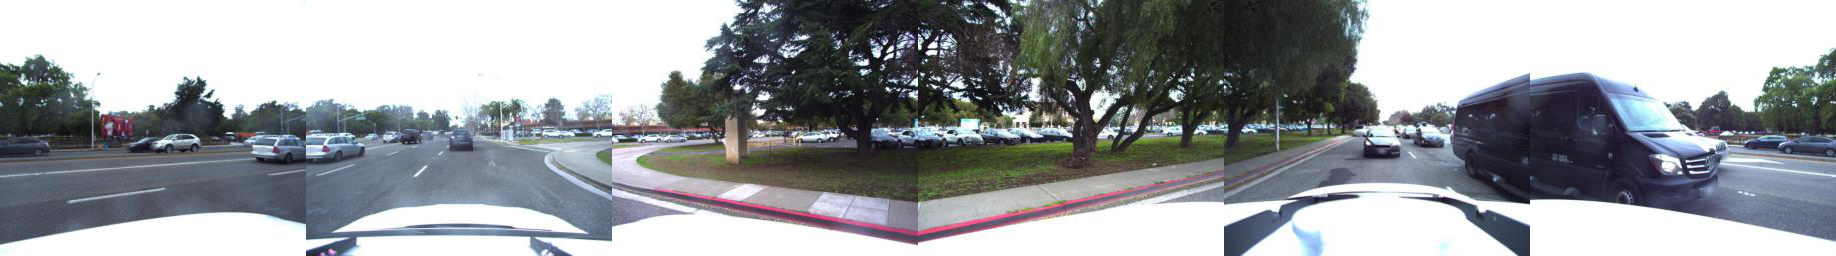

time: 294 ms


In [14]:
images[0]

In [15]:
#set up new training
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2 #4 returned classifier as nan

# get the model using our helper function
#model = get_instance_segmentation_model(num_classes)
model = fr50_Model(True) #try true first

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0001, #reduce from 0.005 to help with the classifer loss = nan issue
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

time: 5.12 s


In [16]:
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch_FastRCNN(model, optimizer, train_data_loader, device, epoch, print_freq=100, panorm = True)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset - this has issues
    #evaluate(model, val_data_loader, device=device)

Epoch: [0]  [   0/2394]  eta: 2:45:36  lr: 0.000100  loss: 1.2235 (1.2235)  loss_classifier: 0.4085 (0.4085)  loss_box_reg: 0.0523 (0.0523)  loss_objectness: 0.6910 (0.6910)  loss_rpn_box_reg: 0.0715 (0.0715)  time: 4.1506  data: 0.4910  max mem: 1065
Epoch: [0]  [ 100/2394]  eta: 0:16:24  lr: 0.000100  loss: 0.9904 (1.0916)  loss_classifier: 0.1915 (0.2328)  loss_box_reg: 0.0470 (0.0595)  loss_objectness: 0.6316 (0.6701)  loss_rpn_box_reg: 0.1320 (0.1291)  time: 0.4026  data: 0.0075  max mem: 1912
Epoch: [0]  [ 200/2394]  eta: 0:14:32  lr: 0.000100  loss: 1.3797 (1.0323)  loss_classifier: 0.2009 (0.1942)  loss_box_reg: 0.0456 (0.0500)  loss_objectness: 0.6219 (0.6484)  loss_rpn_box_reg: 0.4883 (0.1397)  time: 0.3837  data: 0.0079  max mem: 1912
Epoch: [0]  [ 300/2394]  eta: 0:13:40  lr: 0.000100  loss: 0.6670 (0.9670)  loss_classifier: 0.0693 (0.1771)  loss_box_reg: 0.0025 (0.0452)  loss_objectness: 0.5654 (0.6154)  loss_rpn_box_reg: 0.0336 (0.1294)  time: 0.3735  data: 0.0088  max me

In [17]:
#Evaluate on 1 sample

for i, (sample, old_targets, road_image, extra) in enumerate(val_data_loader): #, print_freq, header): 
        
        images = [tt(s).to(device) for s in sew_images_panorm(sample)] #list of [3, 800, 800], should be 1 per patch
        targets = trans_target(old_targets)
        
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        break

time: 905 ms


In [18]:
model.eval()
with torch.no_grad():
     prediction = model(images)

time: 219 ms


In [19]:
prediction

[{'boxes': tensor([[504.8453, 397.4743, 550.6577, 418.0230],
          [512.9061, 381.6413, 557.5285, 401.0905],
          [ 57.4875, 429.7143, 102.6036, 449.4154],
          [488.7356, 373.5306, 533.9327, 393.5600],
          [488.5786, 397.9174, 534.6793, 418.1857],
          [461.4684, 366.1414, 506.5004, 387.0917],
          [448.4586, 341.6735, 494.0128, 361.9015],
          [505.8915, 372.9805, 549.7189, 393.2753],
          [538.2297, 369.6579, 581.8382, 390.3648],
          [448.6802, 349.7547, 493.6741, 370.0255],
          [457.5198, 357.7498, 501.6103, 378.0253],
          [497.4932, 389.6436, 541.5567, 409.4229],
          [ 50.5389, 437.4233,  94.7962, 457.3586],
          [ 33.3428, 453.9633,  79.1267, 474.0577],
          [497.1524, 381.5226, 541.3027, 401.4864],
          [345.7251, 394.2657, 390.8344, 414.2325],
          [350.8233, 385.3937, 395.6781, 405.7338],
          [481.0074, 365.9225, 526.9944, 386.0020],
          [465.5954, 341.6729, 510.4822, 362.0703],
   

time: 33.1 ms


In [20]:
targets

[{'boxes': tensor([[587.7640, 390.4039, 634.5888, 410.7347],
          [723.5701, 494.8876, 770.2949, 515.9766],
          [346.5826, 625.2436, 392.2856, 643.8907],
          [208.3556, 429.6745, 252.5559, 448.8516],
          [103.3553, 430.6902, 147.5497, 449.4175],
          [ 31.1752, 463.0602,  79.2614, 483.2730],
          [340.5685, 465.9312, 384.6458, 484.8769],
          [648.6622, 555.0985, 696.0050, 573.7671],
          [496.1005, 585.7907, 541.8034, 604.4378],
          [519.1313, 464.6352, 561.6338, 483.1805],
          [ 25.9092, 359.7119,  71.8441, 382.5251],
          [716.3273, 617.2219, 763.7090, 636.7295],
          [321.8503, 425.9930, 395.7314, 448.2401],
          [271.5695, 590.2742, 317.2724, 608.9213],
          [384.5264, 589.7536, 430.2294, 608.4007],
          [ 66.1751, 394.0988, 110.3829, 413.8457],
          [256.3764, 392.4210, 300.9099, 411.0828],
          [692.8306, 459.0505, 740.1176, 481.0863],
          [504.9691, 550.0915, 550.6720, 568.7386],
   

time: 77.1 ms


In [21]:
sum([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1])

57

time: 9.33 ms


In [22]:
sum([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

20

time: 9.34 ms


In [25]:
#works with sewing 6 images with 
torch.save({

            'model_state_dict': model.state_dict(),
            }, "../models/fastRCNN_sewpanorm1epoch.pt")

time: 357 ms


In [26]:
#try one without pretrained with reg sew images non panorm
 

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2 #4 returned classifier as nan

# get the model using our helper function
#model = get_instance_segmentation_model(num_classes)
model = fr50_Model(False) #try true first

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0001, #reduce from 0.005 to help with the classifer loss = nan issue
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

time: 2.11 s


In [27]:
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch_FastRCNN(model, optimizer, train_data_loader, device, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler.step()

Epoch: [0]  [   0/2394]  eta: 0:52:45  lr: 0.000100  loss: 5.2910 (5.2910)  loss_classifier: 4.5232 (4.5232)  loss_box_reg: 0.0001 (0.0001)  loss_objectness: 0.7011 (0.7011)  loss_rpn_box_reg: 0.0665 (0.0665)  time: 1.3222  data: 0.5314  max mem: 4404
Epoch: [0]  [ 100/2394]  eta: 0:15:32  lr: 0.000100  loss: 0.8503 (1.2709)  loss_classifier: 0.1341 (0.4829)  loss_box_reg: 0.0144 (0.0101)  loss_objectness: 0.5648 (0.6522)  loss_rpn_box_reg: 0.1390 (0.1257)  time: 0.4044  data: 0.0089  max mem: 4404
Epoch: [0]  [ 200/2394]  eta: 0:14:30  lr: 0.000100  loss: 1.2604 (1.0218)  loss_classifier: 0.2040 (0.2944)  loss_box_reg: 0.0327 (0.0132)  loss_objectness: 0.5359 (0.5730)  loss_rpn_box_reg: 0.4469 (0.1412)  time: 0.3921  data: 0.0082  max mem: 4404
Epoch: [0]  [ 300/2394]  eta: 0:13:44  lr: 0.000100  loss: 0.5197 (0.9240)  loss_classifier: 0.0388 (0.2341)  loss_box_reg: 0.0002 (0.0125)  loss_objectness: 0.4444 (0.5462)  loss_rpn_box_reg: 0.0360 (0.1312)  time: 0.3770  data: 0.0080  max me

In [28]:
#Evaluate on 1 sample

for i, (sample, old_targets, road_image, extra) in enumerate(val_data_loader): #, print_freq, header): 
        
        images = [tt(sew_images(s)).to(device) for s in sample] #list of [3, 800, 800], should be 1 per patch
        targets = trans_target(old_targets)
        
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        break

time: 900 ms


In [29]:
model.eval()
with torch.no_grad():
     prediction = model(images)

time: 214 ms


In [30]:
prediction

[{'boxes': tensor([], device='cuda:0', size=(0, 4)),
  'labels': tensor([], device='cuda:0', dtype=torch.int64),
  'scores': tensor([], device='cuda:0')}]

time: 5.52 ms
